In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from sklearn.model_selection import train_test_split
from functools import reduce
from functools import partial
import operator
from timeit import default_timer
from matplotlib.ticker import FormatStrFormatter
import deepxde as dde
import time

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.
/home/luke/miniconda3/lib/python3.12/site-packages/torch/__init__.py:747: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/torch/csrc/tensor/python_tensor.cpp:431.)
  _C._set_default_tensor_type(t)


In [3]:
def set_size(width, fraction=1, subplots=(1, 1), height_add=0):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = height_add + fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "times",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/bel fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

plt.rcParams.update(tex_fonts)

In [4]:
def solvePDEAdaptive(I, a, L, dt,F, T, lam, solveControl, kernelEstimator, gamma, lamGuess, grid, model, debug):
    # Code adapted from: https://hplgit.github.io/fdm-book/doc/pub/book/pdf/fdm-book-4print.pdf
    Nt = int(round(T/float(dt)))
    t = np.linspace(0, Nt*dt, Nt)  
    dx = np.sqrt(a*dt/F)
    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx+1)      
    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    lArr = []
    kArr = []
    lHat = lamGuess
    lArr.append(lHat)

    u = np.zeros((Nt, Nx+1))

    # Set initial condition u(x,0) = I(x)
    for i in range(0, Nx+1):
        u[0][i] = I[i]
    s= 0
    for i in range(1, Nt):
        kEst = kernelEstimator(lHat, dx, model, grid)
        if i % int(Nt/100) == 0 and debug==True:
            print("i", i, "/", nt)
            print("wTerm", wTerm)
            print("uTerm", uTerm)
            print("lhatdelta", lHatDelta)
            print(time.time() - s)
            s = time.time()
        kArr.append(kEst)
            
        # Compute u at inner mesh points
        u[i][1:Nx] = u[i-1][1:Nx] +  \
                      F*(u[i-1][0:Nx-1] - 2*u[i-1][1:Nx] + u[i-1][2:Nx+1]) + dt*lam[1:Nx]*u[i-1][1:Nx]

        lHatDelta,wTerm, uTerm = estimateLambdaHatDelta(x, u[i-1], kEst, dx, gamma)
        lHat = lHat + dt*lHatDelta
        # Insert boundary conditions
        u[i][0] = 0;  u[i][Nx] = solveControl(u[i], kEst, Nx-1, dx)
        lArr.append(lHat)
    return u, x, lArr, kArr

def solvePDE(I, a, L, dt,F, T, lam, solveControl, kernel):
    # Code adapted from: https://hplgit.github.io/fdm-book/doc/pub/book/pdf/fdm-book-4print.pdf
    Nt = int(round(T/float(dt)))
    t = np.linspace(0, Nt*dt, Nt)  
    dx = np.sqrt(a*dt/F)
    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx+1)      
    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]

    u = np.zeros((Nt, Nx+1))

    # Set initial condition u(x,0) = I(x)
    for i in range(0, Nx+1):
        u[0][i] = I[i]

    for i in range(1, Nt):
        if i % int(Nt/10) == 0:
            print("i", i, "/", nt)
        # Compute u at inner mesh points
        u[i][1:Nx] = u[i-1][1:Nx] +  \
                      F*(u[i-1][0:Nx-1] - 2*u[i-1][1:Nx] + u[i-1][2:Nx+1]) + dt*lam[1:Nx]*u[i-1][1:Nx]

        # Insert boundary conditions
        u[i][0] = 0;  u[i][Nx] = solveControl(u[i], kernel, Nx-1, dx)
    return u

def solveKernelFunction(lam, dx, _a, _b):
    k = np.zeros((len(lam), len(lam)))
    # First we calculate a at each timestep
    a = lam

    # FD LOOP
    k[1][1] = -(a[1] + a[0]) * dx / 4
    for i in range(1, len(lam)-1):
        k[i+1][0] = 0
        k[i+1][i+1] = k[i][i]-dx/4.0*(a[i-1] + a[i])
        k[i+1][i] = k[i][i] - dx/2 * a[i]
        for j in range(1, i):
                k[i+1][j] = -k[i-1][j] + k[i][j+1] + k[i][j-1] + a[j]*(dx**2)*(k[i][j+1]+k[i][j-1])/2
    return k

def solveKernelFunctionNOP(lam, dx, model, grid):
    torchLam = torch.from_numpy(lam).reshape((1, len(lam))).cuda().float()
    out = model((torchLam, grid))
    out = out.cpu().detach().numpy()
    out = np.reshape(out, (len(lam), len(lam)))
    return out

def solveLambdaFunction(x, gamma):
    lam = np.zeros(nx)
    for idx, val in enumerate(x):
        lam[idx] = 5
    return lam

def solveControl(u, kernel, nx, dx):
    return sum(kernel[-1][0:nx+1]*u[0:nx+1])*dx


def openLoop(u, kernel, nx, dx):
    return 0

def zeroToNan(x):
    for i in range(len(x)):
        for j in range(len(x[0])):
            if j >= i:
                x[i][j] = float('nan')
    return x

# PDE L2 Error
def getPDEl2(u, uhat):
    nt = len(u)
    nx = len(u[0])
    pdeError = np.zeros(nt-1)
    for i in range(1, nt):
        error = 0
        for j in range(nx):
            error += (u[i][j] - uhat[i][j])**2
        error = np.sqrt(error*0.01)
        pdeError[i-1] = error
    return pdeError

def solveW(u, kernel, dx):
    w = np.zeros(len(kernel))
    for i in range(0, len(kernel)):
        w[i] = u[i]-sum(kernel[i][0:i]*u[0:i])*dx
    return w

def solveWIntegral(x, w, dx):
    return sum(w[0:]**2)*dx

def estimateLambdaHatDelta(x, u, k, dx, gamma):
    w = solveW(u, k, dx)
    wInt = solveWIntegral(x, w, dx)
    lambdaHat = np.zeros(len(w))
    kt= k.transpose()
    for i in range(0, len(w)):
        middleTerm = (w[i] - sum(kt[i][i:]*w[i:])*dx)*u[i]
        lambdaHat[i] = gamma/(1+wInt)*middleTerm 
    return lambdaHat, wInt, middleTerm

def nanToZero(x):
    for i in range(len(x)):
        for j in range(len(x[0])):
            if j >= i:
                x[i][j] = float('nan')
    return x

def removeTriangle(k):
    newK = k.copy()
    for i in range(len(k)):
        for j in range(len(k)):
            if j>i:
                newK[i][j] = np.nan
    return newK

In [5]:
X = 1
dx = 0.01
nx = int(round(X/dx))
spatial = np.linspace(0, X, nx+1, dtype=np.float32)


T = .5
dt = 0.00001
nt = int(round(T/dt))
temporal = np.linspace(0, T, nt, dtype=np.float32)
print(nt)

50000


In [7]:
# Dataset generation. Keep init_cond, and the guess fixed. 
init_cond = np.zeros(nx+1)
init_cond[:] = 20
lamGuess = np.ones(nx+1)*25
lam = np.zeros(nx+1)
start = time.time()
# Sample every 100 timesteps. Subtract 2 bc kArr only has 49999 elements. 
idxs = np.linspace(0, nt-2, int(nt/100), dtype=np.int64)
x = []
y = []
for i in range(10):
    gamma = np.random.uniform(8.5, 9.5)
    for j in range(len(spatial)):
        lam[j] = 25*math.cos(gamma*math.acos(spatial[j])) +25
    _a, _b, lArr, kArr= solvePDEAdaptive(init_cond, 1, 1, dt, dt/dx**2, T, lam, solveControl, solveKernelFunction, 50, lamGuess, lamGuess, lamGuess, False)
    for val in idxs:
        x.append(lArr[val])
        y.append(kArr[val])
x = np.array(x)
y = np.array(y)
print(x.shape)
print(y.shape)
print("Total Dataset Generation Time:", time.time()-start)
arr_reshaped = y.reshape(y.shape[0], -1)
np.savetxt("y.dat", arr_reshaped)
np.savetxt("x.dat", x)

(500, 101)
(500, 101, 101)
Total Dataset Generation Time: 234.25547862052917


In [6]:
# Parameters
epochs =500
ntrain = 900
ntest = 100
batch_size = 100
gamma = 0.5
learning_rate = 0.001
step_size= 50

grids = []
grids.append(spatial)
grids.append(spatial)
grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T
grid = torch.from_numpy(grid).cuda()
print(grid.shape)

torch.Size([10201, 2])


In [7]:
x = np.loadtxt("x.dat", dtype=np.float32)
y = np.loadtxt("y.dat", dtype=np.float32)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
y_test = torch.from_numpy(y_test).cuda()

trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))

In [8]:
def count_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [9]:
class BranchNet(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape
        self.proj2d = torch.nn.Linear(self.shape, self.shape**2)
        self.conv1 = torch.nn.Conv2d(1, 16, 5, stride=2)
        outShape1 = int((self.shape-(5-1)-1)/2 + 1)
        self.relu = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(16,32, 5, stride=2)
        outShape2 = int((outShape1 - (5-1)-1)/2 + 1)
        self.fc1 = torch.nn.Linear(outShape2**2*32, 1028)
        self.fc2 = torch.nn.Linear(1028, 256)
        
    def forward(self, x):
        x = self.proj2d(x)
        x = torch.reshape(x, (x.shape[0], 1, self.shape, self.shape))
        # shape is batch, 1, nx, nx
        x = self.conv1(x)
        # shape is batch, 16, (nx-(5-1)-1)/2+1, (nx-(5-1)-1)/2+1
        x = self.relu(x)
        x = self.conv2(x)
        # shape is batch, 32, (((nx-(5-1)-1)/2+1) - (5-1)-1)/2+1, (((nx-(5-1)-1)/2+1) - (5-1)-1)/2+1
        x = self.relu(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [14]:
# Define a sequential torch network for batch and trunk. Can use COV2D which we will show later
dim_x = 2
m = (nx+1)**2

branch = BranchNet(nx+1)

model = dde.nn.DeepONetCartesianProd([m, branch], [dim_x, 128, 256, 256], "relu", "Glorot normal").cuda()
print(count_params(model))

18819387


In [68]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [69]:
loss = torch.nn.MSELoss()
train_lossArr = []
test_lossArr = []
time_Arr = []

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_loss = 0
    for x, y in trainData:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model((x, grid))
        
        lp = loss(out, y)
        lp.backward()
        
        optimizer.step()
        train_loss += lp.item()
        
    scheduler.step()
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, y in testData:
            x, y = x.cuda(), y.cuda()
            
            out = model((x, grid))
            test_loss += loss(out, y).item()
            
    train_loss /= len(trainData)
    test_loss /= len(testData)
    
    train_lossArr.append(train_loss)
    test_lossArr.append(test_loss)
    
    t2 = default_timer()
    time_Arr.append(t2-t1)
    if ep%50 == 0:
        print(ep, t2-t1, train_loss, test_loss)

0 0.42060046503320336 3495.4608405219183 354.54478149414064
50 0.25826836191117764 6.462292088402642 5.8294576644897464
100 0.25403216388076544 5.4183390829298235 5.218727493286133
150 0.25614847615361214 4.877499442630344 4.637001609802246
200 0.25205076206475496 4.592277134789361 4.449466037750244
250 0.25662817899137735 4.491221788194444 4.357583618164062
300 0.26058007404208183 4.406549919976128 4.283646202087402
350 0.2555220378562808 4.33249765502082 4.354392433166504
400 0.2524637160822749 4.297119734022353 4.241715431213379
450 0.25268865190446377 4.288329495324029 4.2189685821533205


In [15]:
model.load_state_dict(torch.load("adaptiveNOKernelParabolic"))

<All keys matched successfully>

Avg Epoch Time: 0.25588134180940686
Final Testing Loss: 21.011224269866943
Final Training Loss: 192.38264393806458


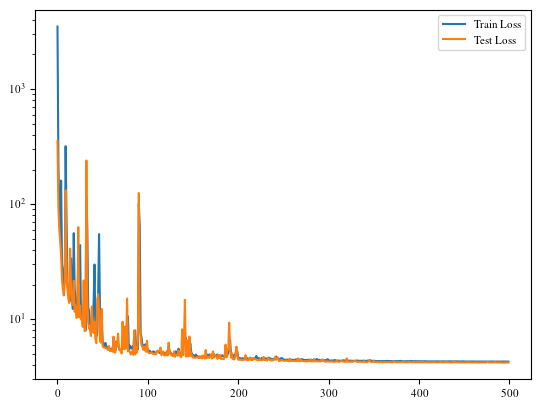

In [70]:
# Display Model Details
plt.figure()
plt.plot(train_lossArr, label="Train Loss")
plt.plot(test_lossArr, label="Test Loss")
plt.yscale("log")
plt.legend()

testLoss = 0
trainLoss = 0
with torch.no_grad():
    for x, y in trainData:
        x, y = x.cuda(), y.cuda()

        out = model((x, grid))
        trainLoss += loss(out, y).item()
        
    for x, y in testData:
        x, y = x.cuda(), y.cuda()

        out = model((x, grid))
        testLoss += loss(out, y).item()
    
    
print("Avg Epoch Time:", sum(time_Arr)/len(time_Arr))
print("Final Testing Loss:", testLoss)
print("Final Training Loss:", trainLoss)

In [16]:
# RUN ADAPTIVE CONTROL
init_cond = np.zeros(nx+1)
lam = np.zeros(nx+1, dtype=np.float32)
lamGuess = np.zeros(nx+1, dtype=np.float32)
for j in range(nx+1):
    init_cond[j] = 20
    lam[j] = 25*math.cos(9*math.acos(spatial[j])) +25
    lamGuess[j] = 25
# kernel with just the guessed lambda without adaptivity
k = solveKernelFunction(lamGuess, dx, lam, lam)

# control with just the guessed lambda without adaptivity
uopen = solvePDE(init_cond, 1, 1, dt, dt/dx**2, T, lam, openLoop, k)

# control with analytic solutions of kernels (SLOW)
u, s2, lArr, kArr= solvePDEAdaptive(init_cond, 1, 1, dt, dt/dx**2, T, lam, solveControl, solveKernelFunction, 50, lamGuess, grid, model, False)

# control with NOP solutions for the kernels.  
uNOP, sNOP, lArrNOP, kArrNOP = solvePDEAdaptive(init_cond, 1, 1, dt, dt/dx**2, T, lam, solveControl, solveKernelFunctionNOP, 50, lamGuess,grid, model, False)

i 5000 / 50000
i 10000 / 50000
i 15000 / 50000
i 20000 / 50000
i 25000 / 50000
i 30000 / 50000
i 35000 / 50000
i 40000 / 50000
i 45000 / 50000


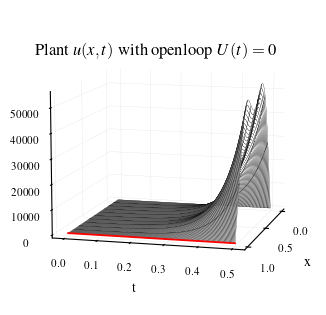

In [72]:
# PLOT CONTROL WITH GUESSED LAMBDA WITHOUT ADAPTIVITY
# PLOT SYSTEM WITH ADAPTIVE CONTROLLER AND NEURAL OPERATOR ESTIMATED GAIN KERNELS
res = 1
fig = plt.figure(figsize=set_size(522, 0.49, (1,1), height_add=0.5))

subfigs = fig.subfigures(nrows=1, ncols=1, hspace=0)

subfig = subfigs
subfig.subplots_adjust(left=0.07, bottom=0, right=1, top=1.1)
subfig.suptitle(r"Plant $u(x, t)$ with openloop $U(t)=0$")
axes = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})

for axis in [axes.xaxis, axes.yaxis, axes.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
    
meshx, mesht = np.meshgrid(spatial, temporal)
                     
axes.plot_surface(meshx, mesht, uopen, edgecolor="black",lw=0.2, rstride=250, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(nt)
vals = (uopen.transpose())[-1] 
axes.plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=True)
axes.view_init(10, 15)
axes.set_xlabel("x")
axes.set_ylabel("t")
axes.set_zlabel(r"$u(x, t)$", rotation=90)
axes.zaxis.set_rotate_label(False)
axes.set_xticks([0, 0.5, 1])
#axes.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.savefig("adaptiveControlOpenLoop.pdf", dpi=300)

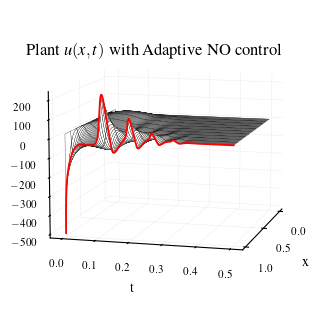

In [36]:
# PLOT SYSTEM WITH ADAPTIVE CONTROLLER AND NEURAL OPERATOR ESTIMATED GAIN KERNELS
res = 1
fig = plt.figure(figsize=set_size(522, 0.49, (1,1), height_add=0.5))

subfigs = fig.subfigures(nrows=1, ncols=1, hspace=0)

subfig = subfigs
subfig.subplots_adjust(left=0.07, bottom=0, right=1, top=1.1)
subfig.suptitle(r"Plant $u(x, t)$ with Adaptive NO control")
axes = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})

for axis in [axes.xaxis, axes.yaxis, axes.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
    
meshx, mesht = np.meshgrid(spatial, temporal)
                     
axes.plot_surface(meshx, mesht, uNOP, edgecolor="black",lw=0.2, rstride=250, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(nt)
vals = (uNOP.transpose())[-1] 
axes.plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=True)
axes.view_init(10, 15)
axes.set_xlabel("x")
axes.set_ylabel("t")
axes.set_zlabel(r"$u(x, t)$", rotation=90)
axes.zaxis.set_rotate_label(False)
axes.set_xticks([0, 0.5, 1])
#axes.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.savefig("adaptiveControlParabolicBig.pdf", dpi=300)

<>:12: SyntaxWarning: invalid escape sequence '\h'
<>:12: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_453727/1612035601.py:12: SyntaxWarning: invalid escape sequence '\h'
  subfig.suptitle("NO estimated kernel $\hat{k}(1, y, t)$")


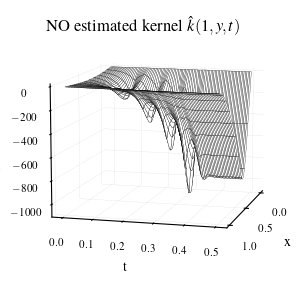

In [99]:
res = 1
kArrNOP = np.array(kArrNOP)
kArr = np.array(kArr)

fig = plt.figure(figsize=set_size(522, 0.49, (1,1), height_add=0.5))

subfigs = fig.subfigures(nrows=1, ncols=1, hspace=0)

subfig = subfigs
subfig.subplots_adjust(left=0.07, bottom=0, right=1, top=1.1)

subfig.suptitle("NO estimated kernel $\hat{k}(1, y, t)$")

subfig.subplots_adjust(left=0.08, bottom=0, right=1, top=1)

axes = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})

for axis in [axes.xaxis, axes.yaxis, axes.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1,1,1))
    
meshx, mesht = np.meshgrid(spatial, temporal[1:])
                     
axes.plot_surface(meshx, mesht, kArrNOP[:, -1, :], edgecolor="black",lw=0.2, rstride=500, cstride=10, 
                  alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
axes.view_init(10, 15)
axes.set_xlabel("x")
axes.set_ylabel("t")
axes.set_zlabel(r"$\hat{k}(1, y, t)$", rotation=90)
axes.zaxis.set_rotate_label(False)
axes.set_xticks([0, 0.5, 1])
axes.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.savefig("adaptiveKernelsTop.pdf", dpi=300)

<>:12: SyntaxWarning: invalid escape sequence '\h'
<>:12: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_453727/3099519540.py:12: SyntaxWarning: invalid escape sequence '\h'
  subfig.suptitle("Kernel error $k(1, y, t) - \hat{k}(1, y, t)$")


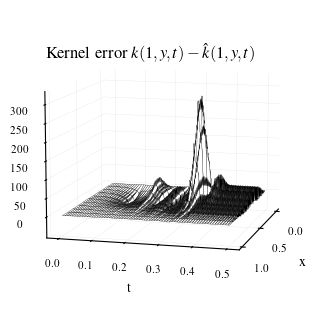

In [100]:
res = 1
kArrNOP = np.array(kArrNOP)
kArr = np.array(kArr)

fig = plt.figure(figsize=set_size(522, 0.49, (1,1), height_add=0.5))

subfigs = fig.subfigures(nrows=1, ncols=1, hspace=0)

subfig = subfigs
subfig.subplots_adjust(left=0.07, bottom=0, right=1, top=1.1)

subfig.suptitle("Kernel error $k(1, y, t) - \hat{k}(1, y, t)$")
axes = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})

for axis in [axes.xaxis, axes.yaxis, axes.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1,1,1))
    
meshx, mesht = np.meshgrid(spatial, temporal[1:])
                     
axes.plot_surface(meshx, mesht, kArr[:, -1, :]-kArrNOP[:, -1, :], edgecolor="black",lw=0.2, rstride=750, cstride=10, 
                  alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
axes.view_init(10, 15)
axes.set_xlabel("x")
axes.set_ylabel("t")
axes.set_zlabel(r"$k(1, y, t) - \hat{k}(1, y, t)$", rotation=90)
axes.zaxis.set_rotate_label(False)
axes.set_xticks([0, 0.5, 1])
axes.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.savefig("adaptiveKernelsBottom.pdf", dpi=300)

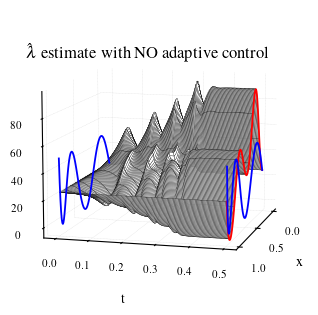

In [101]:
res = 1
kArrNOP = np.array(kArrNOP)
kArr = np.array(kArr)

fig = plt.figure(figsize=set_size(522, 0.49, (1,1), height_add=0.5))

subfigs = fig.subfigures(nrows=1, ncols=1, hspace=0)

subfig = subfigs
subfig.subplots_adjust(left=0.07, bottom=0, right=1, top=1.1)
axes = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})

for axis in [axes.xaxis, axes.yaxis, axes.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
    
meshx, mesht = np.meshgrid(spatial, temporal)
                     
axes.plot_surface(meshx, mesht, lArrNOP, edgecolor="black",lw=0.2, rstride=250, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
axes.view_init(10, 15)
axes.set_xlabel("x")
axes.set_ylabel("t", labelpad=10)
axes.set_zlabel(r"$\hat{\lambda}(x, t)$", rotation=90)
axes.zaxis.set_rotate_label(False)
axes.set_xticks([0, 0.5, 1])
#axes.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
vals = lArr[-1]
test = np.ones(len(lam))*temporal[-1]

axes.plot(spatial, test, vals, color="red", lw=1.3, antialiased=True)
axes.plot(spatial, test, lam, color="blue", lw=1.3, antialiased=True)
axes.plot(spatial, np.zeros(len(lam)), lam, color="blue", lw=1.3, antialiased=True)
subfig.suptitle(r"$\hat{\lambda}$ estimate with NO adaptive control")


plt.savefig("adaptiveLambdaTop.pdf", dpi=300)

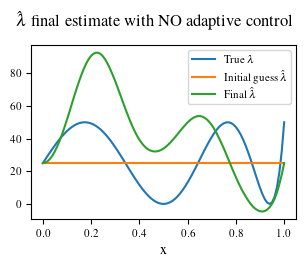

In [102]:
res = 1
kArrNOP = np.array(kArrNOP)
kArr = np.array(kArr)

fig = plt.figure(figsize=set_size(522, 0.49, (1,1), height_add=0.5))

subfigs = fig.subfigures(nrows=1, ncols=1, hspace=0)

subfig = subfigs
subfig.subplots_adjust(left=0.07, bottom=0, right=1, top=1.1)

subfig.subplots_adjust(left=0.15, bottom=0.2, right=0.9, top=0.85, wspace=0.3, hspace=0.1)
axes = subfig.subplots(nrows=1, ncols=1)
axes.plot(spatial, lam, label=r"True $\lambda$")
axes.plot(spatial, lamGuess, label=r"Initial guess $\hat{\lambda}$")
axes.plot(spatial, lArrNOP[-1], label=r"Final  $\hat{\lambda}$")
axes.legend()
axes.set_xlabel("x")
subfig.suptitle(r"$\hat{\lambda}$ final estimate with NO adaptive control")

plt.savefig("adaptiveLambdaBottom.pdf", dpi=300)

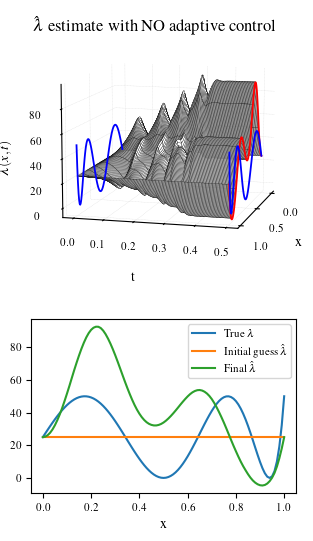

In [76]:
# PLOT LAMBDA ESTIMATES WITH NOP CONTROLLER
lArrNOP = np.array(lArrNOP)
lArr=  np.array(lArr)

res = 1
fig = plt.figure(figsize=set_size(522, 0.49, (2, 1), height_add=1))
subfigs = fig.subfigures(nrows=2, ncols=1, hspace=0)
subfig = subfigs[0]
subfig.subplots_adjust(left=0.08, bottom=0, right=1, top=1)
axes = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})

for axis in [axes.xaxis, axes.yaxis, axes.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
    
meshx, mesht = np.meshgrid(spatial, temporal)
                     
axes.plot_surface(meshx, mesht, lArrNOP, edgecolor="black",lw=0.2, rstride=250, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
axes.view_init(10, 15)
axes.set_xlabel("x")
axes.set_ylabel("t", labelpad=10)
axes.set_zlabel(r"$\hat{\lambda}(x, t)$", rotation=90)
axes.zaxis.set_rotate_label(False)
axes.set_xticks([0, 0.5, 1])
#axes.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
vals = lArr[-1]
test = np.ones(len(lam))*temporal[-1]

axes.plot(spatial, test, vals, color="red", lw=1.3, antialiased=True)
axes.plot(spatial, test, lam, color="blue", lw=1.3, antialiased=True)
axes.plot(spatial, np.zeros(len(lam)), lam, color="blue", lw=1.3, antialiased=True)
subfig.suptitle(r"$\hat{\lambda}$ estimate with NO adaptive control")


subfig = subfigs[1]
# subfig.suptitle(r"Comparison of initial and final $\hat{\beta}$ for $\sigma=2.9, 3.1$")

subfig.subplots_adjust(left=0.15, bottom=0.2, right=0.9, top=0.85, wspace=0.3, hspace=0.1)
axes = subfig.subplots(nrows=1, ncols=1)
axes.plot(spatial, lam, label=r"True $\lambda$")
axes.plot(spatial, lamGuess, label=r"Initial guess $\hat{\lambda}$")
axes.plot(spatial, lArrNOP[-1], label=r"Final  $\hat{\lambda}$")
axes.legend()
axes.set_xlabel("x")

plt.savefig("lambdaComparisonTight.pdf", dpi=300)

<>:8: SyntaxWarning: invalid escape sequence '\h'
<>:8: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_453727/117622872.py:8: SyntaxWarning: invalid escape sequence '\h'
  subfig.suptitle("NO estimated kernel $\hat{k}(1, y, t)$ and\n kernel error $k(1, y, t) - \hat{k}(1, y, t)$")


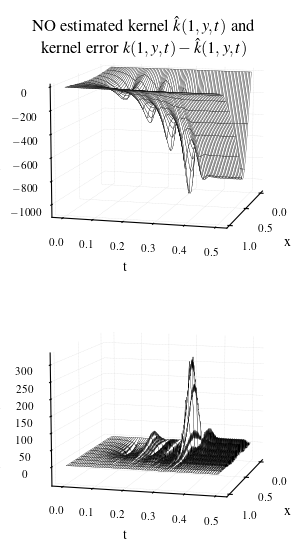

In [71]:
res = 1
fig = plt.figure(figsize=set_size(522, 0.49, (2, 1), height_add=1))
kArrNOP = np.array(kArrNOP)
kArr = np.array(kArr)
subfigs = fig.subfigures(nrows=2, ncols=1, hspace=0)

subfig = subfigs[0]
subfig.suptitle("NO estimated kernel $\hat{k}(1, y, t)$ and\n kernel error $k(1, y, t) - \hat{k}(1, y, t)$")

subfig.subplots_adjust(left=0.08, bottom=0, right=1, top=1)

axes = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})

for axis in [axes.xaxis, axes.yaxis, axes.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1,1,1))
    
meshx, mesht = np.meshgrid(spatial, temporal[1:])
                     
axes.plot_surface(meshx, mesht, kArrNOP[:, -1, :], edgecolor="black",lw=0.2, rstride=500, cstride=10, 
                  alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
axes.view_init(10, 15)
axes.set_xlabel("x")
axes.set_ylabel("t")
axes.set_zlabel(r"$\hat{k}(1, y, t)$", rotation=90)
axes.zaxis.set_rotate_label(False)
axes.set_xticks([0, 0.5, 1])
axes.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

subfig = subfigs[1]
subfig.subplots_adjust(left=0.08, bottom=0, right=1, top=1)

axes = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})

for axis in [axes.xaxis, axes.yaxis, axes.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1,1,1))
    
meshx, mesht = np.meshgrid(spatial, temporal[1:])
                     
axes.plot_surface(meshx, mesht, kArr[:, -1, :]-kArrNOP[:, -1, :], edgecolor="black",lw=0.2, rstride=750, cstride=10, 
                  alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
axes.view_init(10, 15)
axes.set_xlabel("x")
axes.set_ylabel("t")
axes.set_zlabel(r"$k(1, y, t) - \hat{k}(1, y, t)$", rotation=90)
axes.zaxis.set_rotate_label(False)
axes.set_xticks([0, 0.5, 1])
axes.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.savefig("adaptiveKernelsTight.pdf", dpi=300)

In [98]:
a = kArr[:, 1, :]- kArrNOP[:, 1, :]
b =kArr[:, 1, :]
with np.errstate(divide='ignore'):
    result =a /b
    result[b == 0] = 0

print(np.mean(result.flatten()))

-0.004014687256805291


In [22]:
# THIS CODE BUILDS A BEAUTIFUL ANIMATION. NOT INCLUDED IN PAPER BUT I LEAVE IT FOR ANYONE WHO
# WANTS TO VISUALIZE THE ADAPTIVE CONTROL. TO USE:
# First make the directory animation
# Then run this which will save a bunch of files
# Install ffmpeg and run the following command in the animation directory
# ffmpeg -r 5 -i img%03d.png -c:v libx264 -r 30 -pix_fmt yuv420p -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" out.mp4

def savefig(l,truel, u,count, lArr, uArr, val, k, trueK):
    res = 1
    fig = plt.figure(figsize=set_size(600, 0.99, (2, 3), height_add=1.5))
    subfigs = fig.subfigures(nrows=2, ncols=3, hspace=0, wspace=0)

    # PLOT L REGULAR
    subfig = subfigs[1][0]
    axes = subfig.subplots(nrows=1, ncols=1)
    subfig.subplots_adjust(left=0.15, bottom=0.15, right=.85, top=.87)
    axes.plot(np.linspace(0, 1, len(l)), l, label="$\hat{\lambda}$")
    axes.plot(np.linspace(0, 1, len(truel)), truel, label="$\lambda$")
    axes.set_xlabel("x", labelpad=-1, zorder=1)
    axes.set_yticks([-25, 0, 25, 50, 75, 100])
    axes.legend()
    subfig.suptitle(r"$\hat{\lambda}$" + " at $t=${0:.3f}".format(dt*val))

    # PLOT U REGULAR 
    subfig = subfigs[1][1]
    axes = subfig.subplots(nrows=1, ncols=1)
    subfig.subplots_adjust(left=0.15, bottom=0.15, right=.85, top=Nader Meskin.87)
    axes.plot(np.linspace(0, 1, len(u)), u)
    axes.set_xlabel("x", labelpad=-1, zorder=1)
    axes.set_yticks([-500, -250, 0, 250, 500])
    axes.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    subfig.suptitle("$u$ at $t=${0:.3f}".format(dt*val))

    # PLOT L 3D 
    subfig = subfigs[0][0]
    subfig.subplots_adjust(left=0.0, bottom=0.05, right=1, top=1.05)
    axes = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})
    lArr=  np.array(lArr)
    
    for axis in [axes.xaxis, axes.yaxis, axes.zaxis]:
        axis._axinfo['axisline']['linewidth'] = 1
        axis._axinfo['axisline']['color'] = "b"
        axis._axinfo['grid']['linewidth'] = 0.2
        axis._axinfo['grid']['linestyle'] = "--"
        axis._axinfo['grid']['color'] = "#d1d1d1"
        axis.set_pane_color((1, 1, 1))
        
    meshx, mesht = np.meshgrid(spatial, temporal)
    plotVals = lArr
    plotVals[val:] = np.nan
                         
    axes.plot_surface(meshx, mesht, plotVals, edgecolor="black",lw=0.2, rstride=250, cstride=10, 
                            alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
    # axes.set_ylim(0, val*dt)
    axes.view_init(10, 15)
    axes.set_xlabel("x")
    axes.set_ylabel("time", labelpad=2)

    axes.zaxis.set_rotate_label(False)


    vals = lArr[val-1]
    test = np.ones(len(lam))*(val*dt)
    
    axes.plot(spatial, test, vals, color="red", lw=1.3, antialiased=True)
    axes.plot(spatial, np.zeros(len(test)), truel, color="blue", lw=1.3, antialiased=True)
    # axes.plot(spatial[0:count], np.zeros(len(lam)), lam, color="blue", lw=1.3, antialiased=True)
    subfig.suptitle("$\hat{\lambda}$ estimate with NO kernels")
    axes.set_xticks([0, 0.5, 1])
    axes.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
    axes.set_zticks([-25, 0, 25, 50, 75, 100])


    # ################
    # U PLOT 3D
    subfig = subfigs[0][1]
    subfig.suptitle("u(x, t) with NO kernels")

    subfig.subplots_adjust(left=0.0, bottom=0.05, right=1, top=1.05)
    axes = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})
    
    for axis in [axes.xaxis, axes.yaxis, axes.zaxis]:
        axis._axinfo['axisline']['linewidth'] = 1
        axis._axinfo['axisline']['color'] = "b"
        axis._axinfo['grid'][
class
torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)[source]
'linewidth'] = 0.2
        axis._axinfo['grid']['linestyle'] = "--"
        axis._axinfo['grid']['color'] = "#d1d1d1"
        axis.set_pane_color((1, 1, 1))
        
    meshx, mesht = np.meshgrid(spatial, temporal)
    plotVals = uArr.copy()
    plotVals[val:] = np.nan
                         self.shape**2
    axes.plot_surface(meshx, mesht, plotVals, edgecolor="black",lw=0.2, rstride=250, cstride=10, 
                            alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
    # axes.set_ylim(0, val*dt)
    axes.view_init(10, 15)
    axes.set_xlabel("x")
    axes.set_ylabel("time", labelpad=2)

    axes.zaxis.set_rotate_label(False)
    #axes.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
  
    test = np.ones(nt)
    values = (uArr.transpose())[-1] 
    values[val:] = np.nan
    axes.plot(test[1:], temporal[1:], values[1:], color="red", lw=1.3, antialiased=True)
    axes.set_xticks([0, 0.5, 1])
    axes.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
    axes.set_zticks([-500, -250, 0, 250, 500])

    # ################
    # kernel PLOT 
    subfig = subfigs[0][2]
    subfig.suptitle("NOP Approx Kernel at $t=${0:.3f}".format(dt*val))

    subfig.subplots_adjust(left=0.0, bottom=0.05, right=1, top=1.05)
    axes = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})
    
    for axis in [axes.xaxis, axes.yaxis, axes.zaxis]:
        axis._axinfo['axisline']['linewidth'] = 1
        axis._axinfo['axisline']['color'] = "b"
        axis._axinfo['grid']['linewidth'] = 0.2
        axis._axinfo['grid']['linestyle'] = "--"
        axis._axinfo['grid']['color'] = "#d1d1d1"
        axis.set_pane_color((1, 1, 1))
        
    meshx, mesht = np.meshgrid(spatial, spatial)
    plotVals = nanToZero(removeTriangle(k.copy()))
                         
    axes.plot_surface(meshx, mesht, plotVals, edgecolor="black",lw=0.2, rstride=1, cstride=10, 
                            alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
    # axes.set_ylim(0, val*dt)
    axes.view_init(10, 15)
    axes.set_xlabel("y")
    axes.set_ylabel("x")

    axes.zaxis.set_rotate_label(False)
    #axes.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
  
    axes.set_xticks([0, 0.5, 1])
    axes.set_yticks([0, 0.5, 1])
    axes.set_zticks([-1000, -500, 0, 500])

    # ################
    # kernel ERROR PLOT 
    subfig = subfigs[1][2]
    subfig.suptitle("\% NOP Kernel Error \n at $t=${0:.3f}".format(dt*val))

    subfig.subplots_adjust(left=0.0, bottom=0.05, right=1, top=1.05)
    axes = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})
    
    for axis in [axes.xaxis, axes.yaxis, axes.zaxis]:
        axis._axinfo['axisline']['linewidth'] = 1
        axis._axinfo['axisline']['color'] = "b"
        axis._axinfo['grid']['linewidth'] = 0.2
        axis._axinfo['grid']['linestyle'] = "--"
        axis._axinfo['grid']['color'] = "#d1d1d1"
        axis.set_pane_color((1, 1, 1))
        
    meshx, mesht = np.meshgrid(spatial, spatial)
                         
    axes.plot_surface(meshx, mesht, nanToZero((trueK-k)/trueK), edgecolor="black",lw=0.2, rstride=1, cstride=10, 
                            alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
    # axes.set_ylim(0, val*dt)
    axes.view_init(10, 15)
    axes.set_xlabel("y")
    axes.set_ylabel("x")

    axes.zaxis.set_rotate_label(False)
    #axes.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
  
    axes.set_xticks([0, 0.5, 1])
    axes.set_yticks([0, 0.5, 1])
    axes.set_zticks([-3, -1.5, 0, 1.5, 3])

    
    stringVal = "animation/img" +str( count).zfill(3) + ".png"
    plt.savefig(stringVal, dpi=300)
    plt.close()
for i in range(0, len(lArr), 500):
    v1 = u[i].copy()
    v2 = u.copy()
    trueKernel = solveKernelFunction(lArr[i], dx, model, grid)
    savefig(lArr[i], lam, v1, int(i/500), lArr, v2, i, kArrNOP[i], trueKernel)

<>:13: SyntaxWarning: invalid escape sequence '\h'
<>:14: SyntaxWarning: invalid escape sequence '\l'
<>:64: SyntaxWarning: invalid escape sequence '\h'
<>:144: SyntaxWarning: invalid escape sequence '\%'
<>:13: SyntaxWarning: invalid escape sequence '\h'
<>:14: SyntaxWarning: invalid escape sequence '\l'
<>:64: SyntaxWarning: invalid escape sequence '\h'
<>:144: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_1333856/2914381507.py:13: SyntaxWarning: invalid escape sequence '\h'
  axes.plot(np.linspace(0, 1, len(l)), l, label="$\hat{\lambda}$")
/tmp/ipykernel_1333856/2914381507.py:14: SyntaxWarning: invalid escape sequence '\l'
  axes.plot(np.linspace(0, 1, len(truel)), truel, label="$\lambda$")
/tmp/ipykernel_1333856/2914381507.py:64: SyntaxWarning: invalid escape sequence '\h'
  subfig.suptitle("$\hat{\lambda}$ estimate with NO kernels")
/tmp/ipykernel_1333856/2914381507.py:144: SyntaxWarning: invalid escape sequence '\%'
  subfig.suptitle("\% NOP Kernel Error \n at $t=${0

<>:15: SyntaxWarning: invalid escape sequence '\l'
<>:15: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1333856/209945295.py:15: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title("$\lambda(x)$ with different $\gamma$")


Text(0.5, 1.0, '$\\lambda(x)$ with different $\\gamma$')

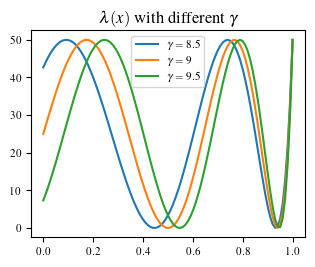

In [52]:
# BONUS EXAMPLES OF CHEBYSHEV POLYNOMIALS WITH DIFFERENT $\gamma$
res = 1
def solveChebyshev(gamma, spatial):
    lam =  np.zeros(len(spatial))
    for j in range(len(spatial)):
        lam[j] = 25*math.cos(gamma*math.acos(spatial[j])) +25
    return lam
fig = plt.figure(figsize=set_size(522, 0.49, (1,1), height_add=0.5))

ax = fig.subplots(nrows=1, ncols=1)
ax.plot(spatial, solveChebyshev(8.5, spatial), label=r"$\gamma=8.5$")
ax.plot(spatial, solveChebyshev(9, spatial), label=r"$\gamma=9$")
ax.plot(spatial, solveChebyshev(9.5, spatial), label=r"$\gamma=9.5$")
ax.legend()
ax.set_title("$\lambda(x)$ with different $\gamma$")

In [55]:
# Time comparison for entire sim
# control with analytic solutions of kernels (SLOW)
s = time.time()
u, s2, lArr, kArr= solvePDEAdaptive(init_cond, 1, 1, dt, dt/dx**2, T, lam, solveControl, solveKernelFunction, 50, lamGuess, grid, model, False)
timeFD = time.time()-s
print("Finite difference kernel", timeFD)
# control with NOP solutions for the kernels.  
s = time.time()
uNOP, sNOP, lArrNOP, kArrNOP = solvePDEAdaptive(init_cond, 1, 1, dt, dt/dx**2, T, lam, solveControl, solveKernelFunctionNOP, 50, lamGuess,grid, model, False)
timeNOP = time.time()-s
print("Neural Operator kernel", timeNOP)

Finite difference kernel 297.32183861732483
Neural Operator kernel 73.7492127418518


In [53]:
with torch.no_grad():
# Time comparison for different spatial step sizes
    # dx = 0.05
    print("Given times are in milliseconds")
    X = 1
    dx = 0.05
    nx = int(round(X/dx))
    spatial = np.linspace(0, X, nx+1, dtype=np.float32)
    dim_x = 2
    m = (nx+1)**2
    branch = BranchNet(nx+1)
    lam = torch.from_numpy(np.reshape(spatial, (1, nx+1))).float().cuda()
    
    grids = []
    grids.append(spatial)
    grids.append(spatial)
    grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T
    grid = torch.from_numpy(grid).cuda()
    model = dde.nn.DeepONetCartesianProd([m, branch], [dim_x, 128, 256, 256], "relu", "Glorot normal").cuda()
    s = time.time()
    for i in range(100):
        out = model((lam, grid))
    timeNOP = time.time()-s
    s = time.time()
    for i in range(100):
        out = solveKernelFunction(spatial, dx, model, grid)
    timeFD = time.time()-s
    print("Neural Operator Kernel dx", dx, "time:", timeNOP/100*1000)
    print("FD Kernel dx", dx, "time:", timeFD/100*1000)
    print("Speedup for dx", dx, "is", timeFD/timeNOP)
    
    # Time comparison for different spatial step sizes
    # dx = 0.01
    X = 1
    dx = 0.01
    nx = int(round(X/dx))
    spatial = np.linspace(0, X, nx+1, dtype=np.float32)
    lam = torch.from_numpy(np.reshape(spatial, (1, nx+1))).float().cuda()
    dim_x = 2
    m = (nx+1)**2
    branch = BranchNet(nx+1)
    
    grids = []
    grids.append(spatial)
    grids.append(spatial)
    grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T
    grid = torch.from_numpy(grid).cuda()
    model = dde.nn.DeepONetCartesianProd([m, branch], [dim_x, 128, 256, 256], "relu", "Glorot normal").cuda()
    s = time.time()
    for i in range(100):
        out = model((lam, grid))
    timeNOP = time.time()-s
    s = time.time()
    for i in range(100):
        out = solveKernelFunction(spatial, dx, model, grid)
    timeFD = time.time()-s
    print("Neural Operator Kernel dx", dx, "time:", timeNOP/100*1000)
    print("FD Kernel dx", dx, "time:", timeFD/100*1000)
    print("Speedup for dx", dx, "is", timeFD/timeNOP)
    
    # Time comparison for different spatial step sizes
    # dx = 0.005
    X = 1
    dx = 0.005
    nx = int(round(X/dx))
    spatial = np.linspace(0, X, nx+1, dtype=np.float32)
    dim_x = 2
    m = (nx+1)**2
    branch = BranchNet(nx+1)
    lam = torch.from_numpy(np.reshape(spatial, (1, nx+1))).float().cuda()
    grids = []
    grids.append(spatial)  
    grids.append(spatial)
    grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T
    grid = torch.from_numpy(grid).cuda()
    model = dde.nn.DeepONetCartesianProd([m, branch], [dim_x, 128, 256, 256], "relu", "Glorot normal").cuda()
    s = time.time()
    for i in range(100):
        out = model((lam, grid))
    timeNOP = time.time()-s
    s = time.time()
    for i in range(100):
        out = solveKernelFunction(spatial, dx, model, grid)
    timeFD = time.time()-s
    print("Neural Operator Kernel dx", dx, "time:", timeNOP/100*1000)
    print("FD Kernel dx", dx, "time:", timeFD/100*1000)
    print("Speedup for dx", dx, "is", timeFD/timeNOP)

Given times are in milliseconds
Neural Operator Kernel dx 0.05 time: 0.32532215118408203
FD Kernel dx 0.05 time: 0.41597843170166016
Speedup for dx 0.05 is 1.2786661780872115
Neural Operator Kernel dx 0.01 time: 0.28211116790771484
FD Kernel dx 0.01 time: 9.861624240875244
Speedup for dx 0.01 is 34.956518432128185
Neural Operator Kernel dx 0.005 time: 0.8688044548034668
FD Kernel dx 0.005 time: 39.88210201263428
Speedup for dx 0.005 is 45.90457817306663
